<a href="https://colab.research.google.com/github/No1Talent/DLSelfDrivingCars/blob/master/Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep

## Pack and Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models,transforms,datasets # handling deep learning models, image transformations, and datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


Initial Import

```
# download and unzip
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
!unzip data.zip
%ls

# remove unnecessary
!rm data.zip
!rm -r __MACOSX

# save data to MyDrive
from google.colab import drive
drive.mount('/content/drive')
!mv data "/content/drive/MyDrive/"
```


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/')

%pwd

MessageError: ignored

In [ ]:
import csv
from torch.utils.data import random_split

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

# Split the data into training and validation sets
train_len = int(0.8 * len(samples))
train_samples, validation_samples = random_split(samples, [train_len, len(samples) - train_len])

In [ ]:
# samples.head
len(samples), samples[:1]

In [ ]:
data = pd.read_csv('data/driving_log.csv')
data.head()
# data.iloc[1]

## Balanced Sampling

In [21]:
# First, identify the indices where steering is 0
zero_steering_indices = data[data['steering'] == 0].index

# Calculate the number of indices to drop (30% of the total zero steering data)
num_indices_to_drop = int(0.5 * len(zero_steering_indices))

# Randomly select indices to drop
indices_to_drop = np.random.choice(zero_steering_indices, size=num_indices_to_drop, replace=False)

# Drop the selected indices from the DataFrame
data_ds = data.drop(indices_to_drop)

<Axes: xlabel='steering', ylabel='Count'>

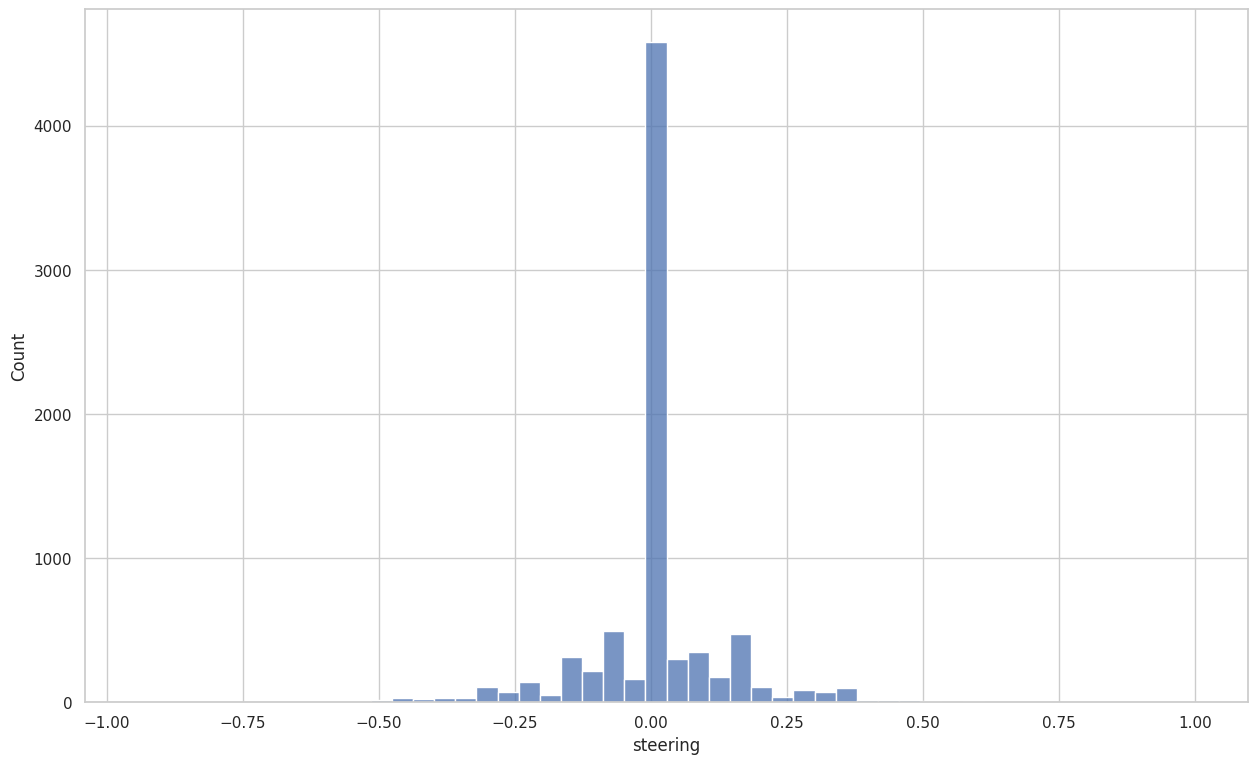

In [6]:
# data["steering"].describe()
# plt.hist(data["steering"])
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'whitegrid')
plt.figure(figsize = (15,9))
sns.histplot(data["steering"], bins = 50)

<Axes: xlabel='steering', ylabel='Count'>

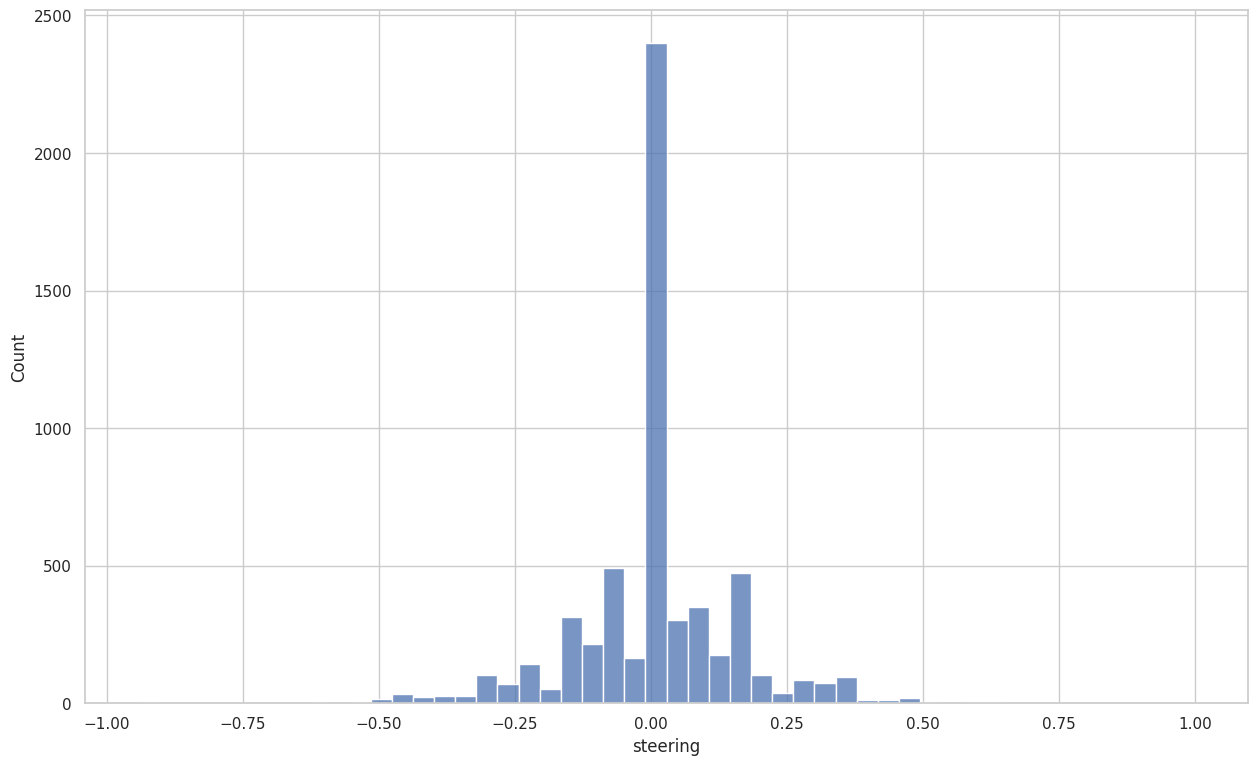

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'whitegrid')
plt.figure(figsize = (15,9))
sns.histplot(data_ds["steering"], bins = 50)

# Image Preprocessing and Augmentation

[reference](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py)

In [6]:
from torchvision.io import read_image

def path_to_img(img_path):
  img_path = str(img_path)
  img = read_image(f'data/IMG/{img_path.split("/")[-1]}')
  return img

def cropping(img):
  img = img[:, 20:55, :] #picture-level
  # img = img[: ,60:140, :] # batch-level [RGB0:3, row_from:to, col_from: to]

In [7]:
from torchvision import models,transforms,datasets
from torchvision.transforms import v2

transformations = v2.Compose([
    v2.ToTensor(),  # Convert to tensor, only needed if you had a PIL image
    # v2.ToDtype(torch.uint8, scale=True),  # input are already uint8
    v2.Resize(size=(66,200), antialias=True), # v2.RandomResizedCrop(size=(224, 224), antialias=True)
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=(66, 200), scale=(0.8, 1.0), ratio=(0.75, 1.333), interpolation=2),
    v2.ToDtype(torch.float32, scale=True)  # Normalize expects float input
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # to improve GPU processing speed
])
# antialias=True to smooth the edges of images or graphics to reduce aliasing artifacts, such as jagged edges or flickering


'''
import torchvision.transforms as transforms
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
'''

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


'\nimport torchvision.transforms as transforms\ntransformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])\n'

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
# overwrite plt.imshow
def imshow(img, title=None, normalization = False):
  img = img.numpy().transpose((1, 2, 0))
  if normalization:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
  img = np.clip(img,0,1)
  # Clipping input data to the valid range for imshow with RGB data
  # [0,1] for floats or [0,255] for integers
  plt.imshow(img)
  if title is not None:
    plt.title(title)

In [9]:
# sum it up
def random_flip(img, angle):
  if np.random.rand() < 0.5:
    img = cv2.flip(img, 1)
    angle = -angle
  return img, angle

def random_augment(img, angle):
  v2.RandomHorizontalFlip(p=0.5)
  if np.random.rand() < 0.5:
    jitter = v2.ColorJitter(brightness=.5, hue=.3)
    img = jitter(img)
  if np.random.rand() < 0.5:
    img, angle = random_flip(img, angle)
  if np.random.rand() < 0.5:
    blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
    img = blurrer(img)
  return img, angle

# Dataset Reading, Loading and Batching

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class CarImageDataset(Dataset):
    def __init__(self, samples, transform = None, crop = None, augment=None):
      self.samples = samples
      self.transform = transform # function default to = None, not = False
      self.augment = augment
      self.crop = crop

    def __getitem__(self, index):
      # get a batch
      batch_samples = self.samples[index]
      # read-in Y
      steering_angle = float(batch_samples[3])
      # read-in X
      center_img, left_img, right_img = batch_samples[:3]
      # img_path to img
      center_img, left_img, right_img = path_to_img(center_img), path_to_img(left_img),path_to_img(right_img)
      # randomly augment X
      if self.augment:
          center_img,angle_center = random_augment(center_img, steering_angle)
          left_img,angle_left = random_augment(left_img, steering_angle + 0.4)
          right_img,angle_right = random_augment(right_img, steering_angle - 0.4 )
      else:
        angle_center = steering_angle
        angle_left = steering_angle + 0.4
        angle_right = steering_angle - 0.4
      # don't crop or transform here: raise Runtime Error...
      # cropping
      # center_img, left_img, right_img = self.crop(center_img), self.crop(left_img), self.crop(right_img)
      # transform
      center_img, left_img, right_img = self.transform(center_img), self.transform(left_img), self.transform(right_img)
      return (center_img, angle_center), (left_img, angle_left), (right_img, angle_right)

    def __len__(self):
      return len(self.samples)


In [11]:
dset_train = CarImageDataset(train_samples, transform = transformations, crop = cropping)
loader_train = DataLoader(dset_train, batch_size=128, shuffle=True, num_workers=6)
# params = {'batch_size': 32, 'shuffle': True, 'num_workers': 4}
# loader_train = data.DataLoader(dset_train, **params)

dset_valid = CarImageDataset(validation_samples, transform = transformations, crop = cropping)
loader_valid = DataLoader(dset_valid, batch_size=128, shuffle=False, num_workers=6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# get a batch for testing and plotting

In [15]:
# get a batch for plotting
(center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right) = next(iter(loader_train))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

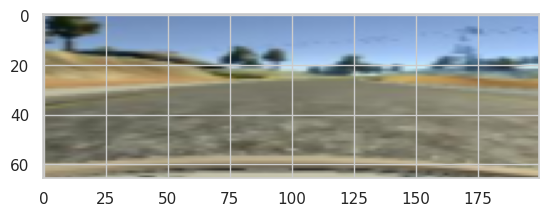

In [16]:
imshow(center_img[0])

In [17]:
center_img.shape, center_img[0].shape
# [batch_size, RGB, H, W]
# (3 x H x W)

(torch.Size([128, 3, 66, 200]), torch.Size([3, 66, 200]))

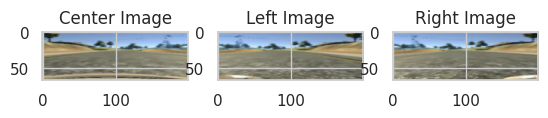

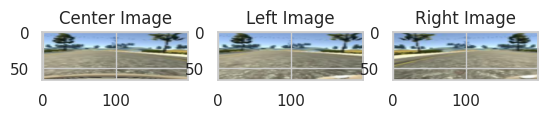

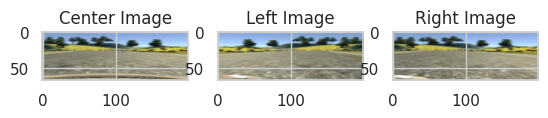

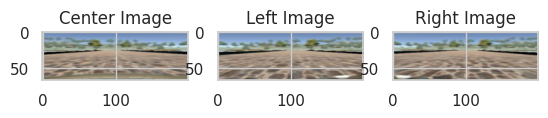

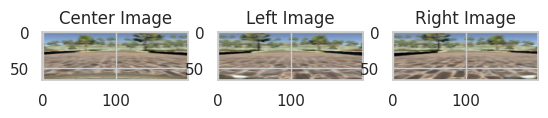

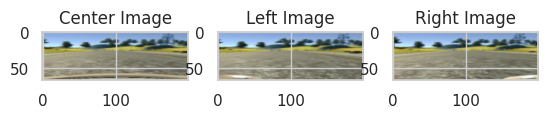

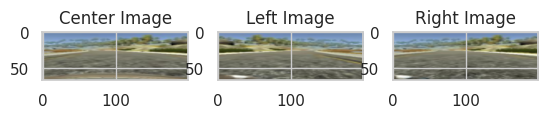

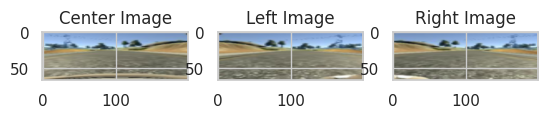

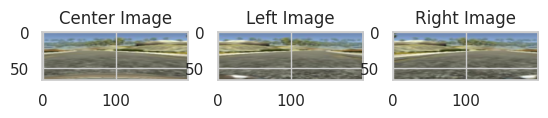

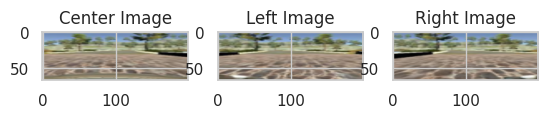

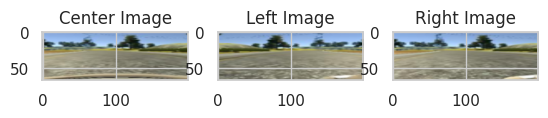

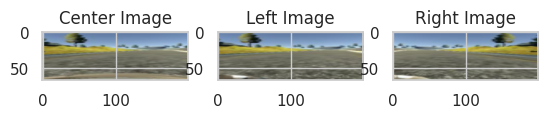

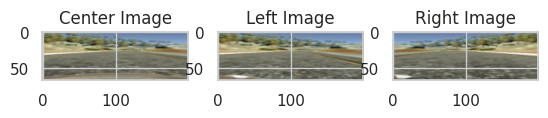

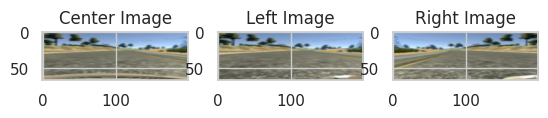

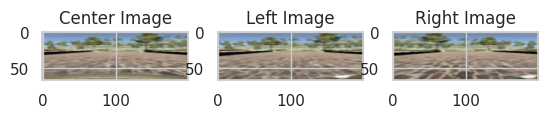

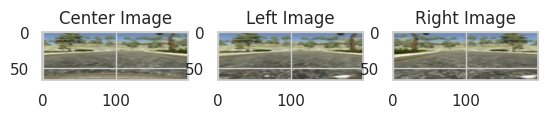

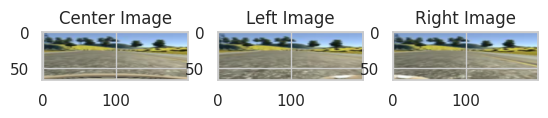

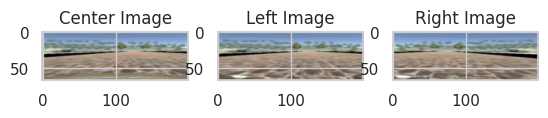

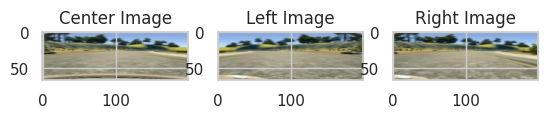

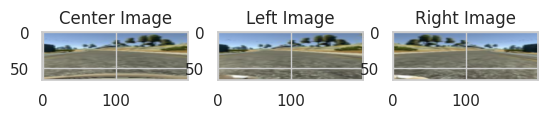

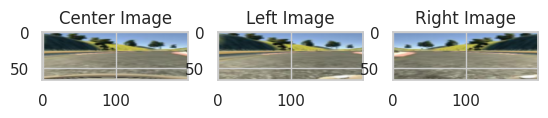

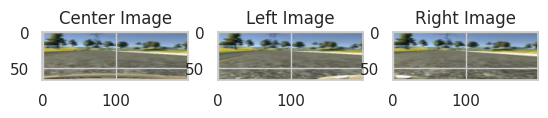

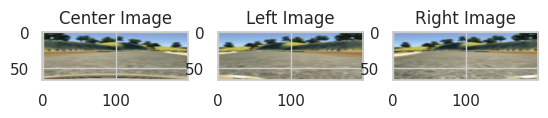

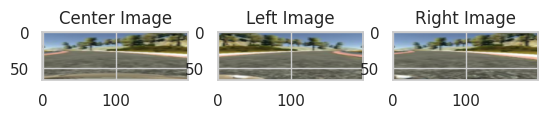

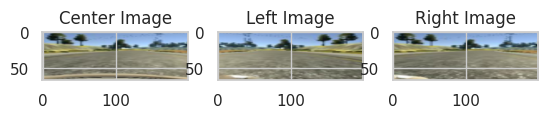

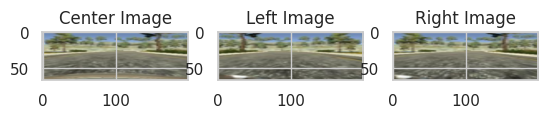

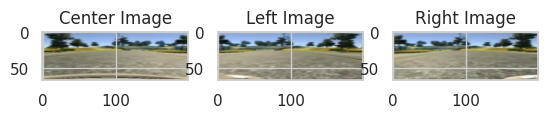

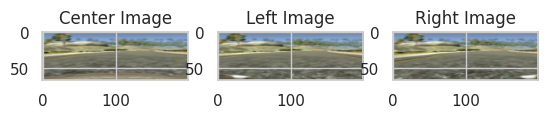

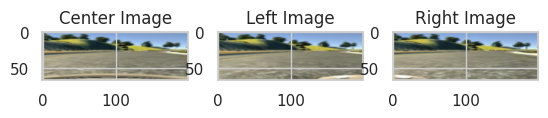

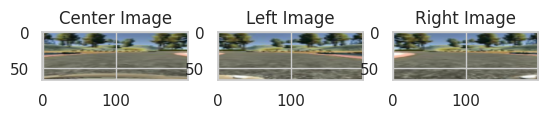

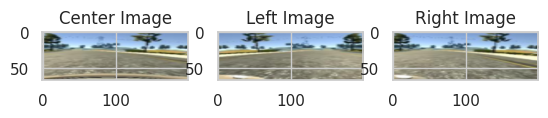

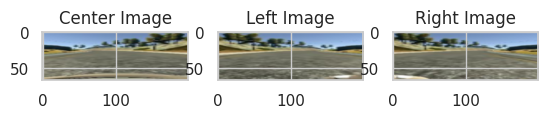

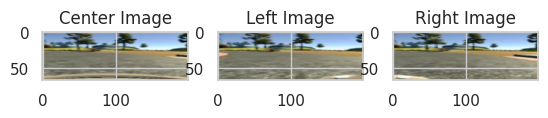

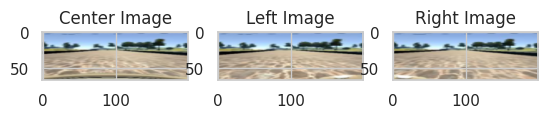

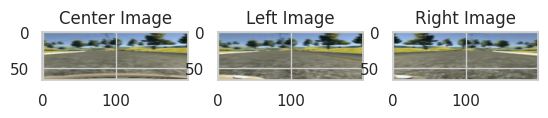

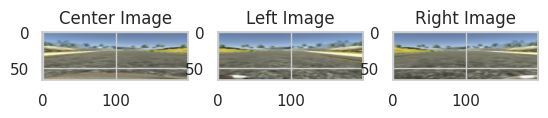

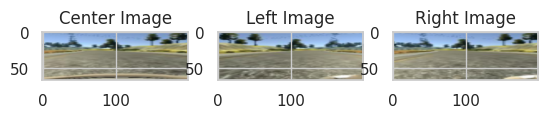

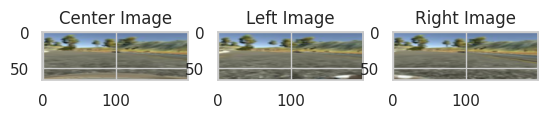

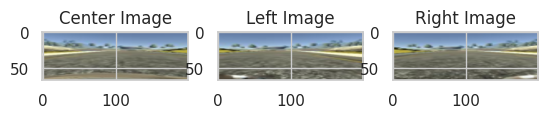

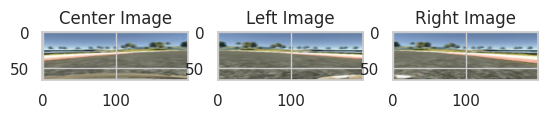

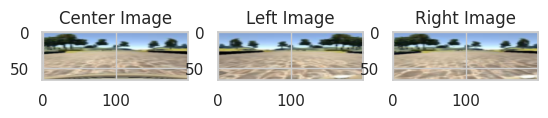

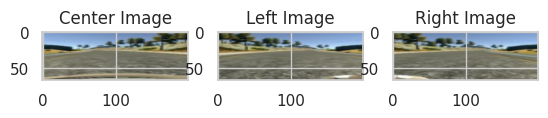

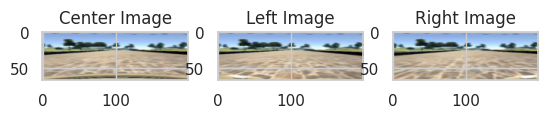

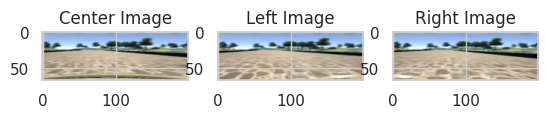

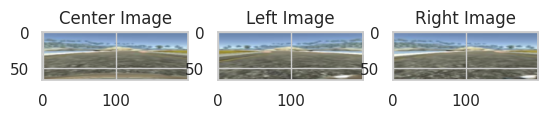

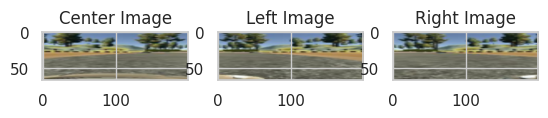

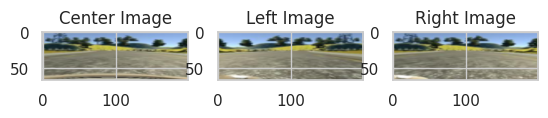

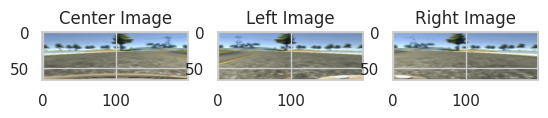

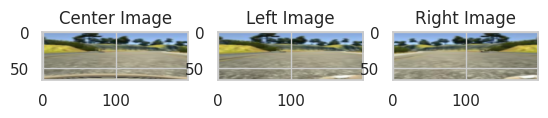

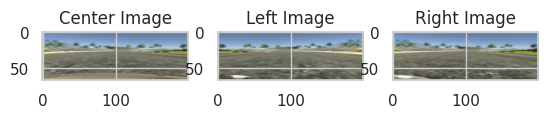

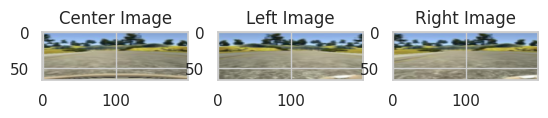

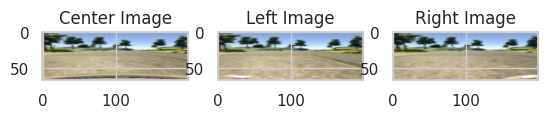

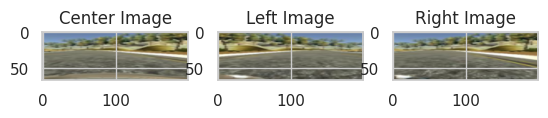

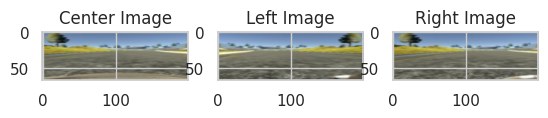

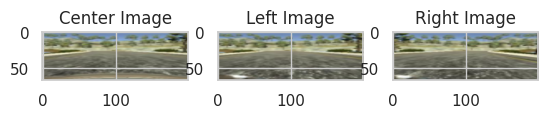

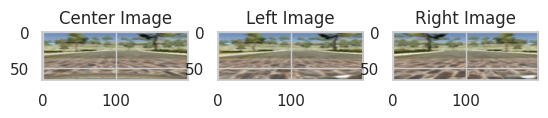

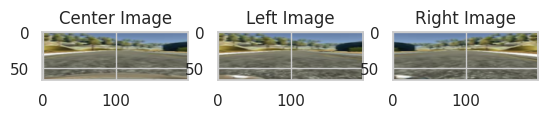

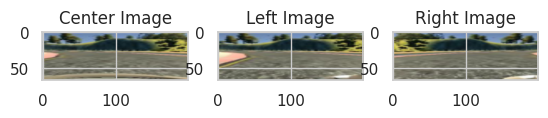

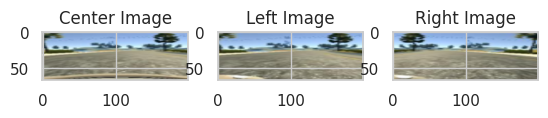

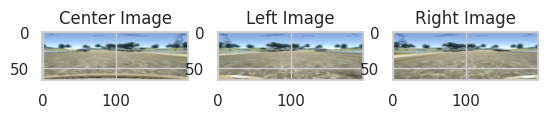

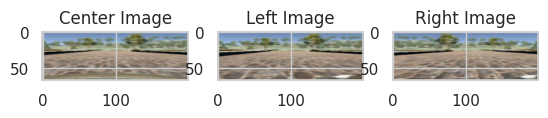

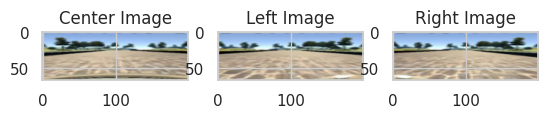

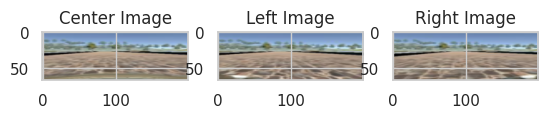

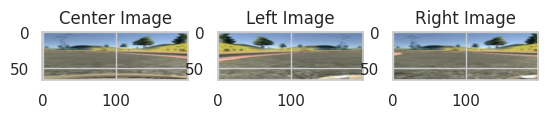

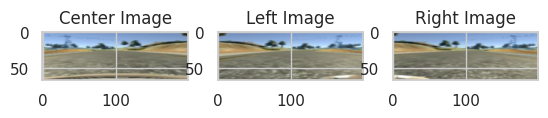

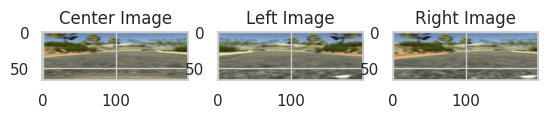

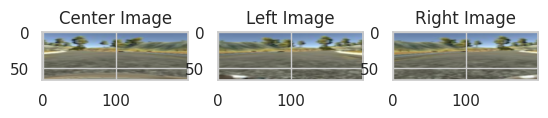

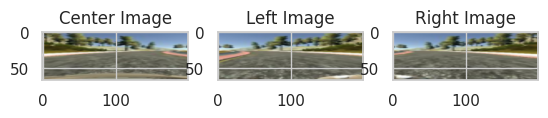

In [18]:
# Visualize the batch of images
for i in range(len(center_img)-60):
    # Display Center Image
    plt.subplot(1, 3, 1)
    imshow(center_img[i], title="Center Image")

    # Display Left Image
    plt.subplot(1, 3, 2)
    imshow(left_img[i], title="Left Image")

    # Display Right Image
    plt.subplot(1, 3, 3)
    imshow(right_img[i], title="Right Image")

    plt.show()

# Model Architecture

## Adapted NVIDIA Model
    - the convolution layers are meant to handle feature engineering
    - the fully connected layer for predicting the steering angle.
    - dropout avoids overfitting
    - ELU(Exponential linear unit) function takes care of the Vanishing gradient problem.
    
### Light Model

```
  (module): CarSimpleModel (
    (conv_layers): Sequential (
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): ELU (alpha=1.0)
      (2): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (3): MaxPool2d (size=(4, 4), stride=(4, 4), dilation=(1, 1))
      (4): Dropout (p = 0.25)
    )
    (linear_layers): Sequential (
      (0): Linear (3648 -> 50)
      (1): ELU (alpha=1.0)
      (2): Linear (50 -> 10)
      (3): Linear (10 -> 1)
    )
  )
```

## Nvidia Model
![title](https://www.researchgate.net/profile/Mathew-Monfort/publication/301648615/figure/fig4/AS:357938163142666@1462350516717/CNN-architecture-The-network-has-about-27-million-connections-and-250-thousand.png)

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        # Imput images: 3@66*200
        # Conv Layers (W1, W2, F, S = 1, P = 0)
        # output_size = (W - F + 2P)/S + 1
        self.conv1 = nn.Conv2d(3, 24, 5, 2) # 24@31*98
        self.conv2 = nn.Conv2d(24, 36, 5, 2) # 36@14*47
        self.conv3 = nn.Conv2d(36, 48, 5, 2) # 48@5*22
        self.conv4 = nn.Conv2d(48, 64, 3) #64@2*20
        self.conv5 = nn.Conv2d(64, 64, 3) #64@1*18
        self.dropout1 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*1*18, 100)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(50, 10)
        self.dropout4 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.elu(self.fc1(x))
        x = self.dropout2(x)
        x = F.elu(self.fc2(x))
        x = self.dropout3(x)
        x = F.elu(self.fc3(x))
        x = self.dropout4(x)
        x = self.fc4(x)
        return x

In [4]:
model = NvidiaModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

## Light Net 1 DL

proposed by

In [4]:
def cal_CNN_output_size(input_height, input_width, K, S = 1, P = 0):
    """
    Calculate the output size of a convolutional layer.
    Returns:
    - tuple: Tuple representing the output size (height, width).
    """

    output_height = ((input_height - K + 2 * P) / S) + 1
    output_width = ((input_width - K + 2 * P) / S) + 1

    return int(output_height), int(output_width)

In [ ]:
def cal_MP_output_size()

In [3]:
cal_CNN_output_size(66, 200, 3,2)
cal_CNN_output_size(32, 99, 3,2)

(15, 49)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkLight(nn.Module):
    def __init__(self):
        super(NetworkLight, self).__init__()
        # Imput images: 3@66*200
        # Conv Layers (W1, W2, F, S = 1, P = 0)
        # output_size = (W - F + 2P)/S + 1

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=2) # 24@32*99
        self.conv2 = nn.Conv2d(24, 48, kernel_size=3, stride=2) # 48@15*49
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4) #
        self.dropout = nn.Dropout(p=0.25)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=48*3*12, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, input):
        input = input.view(input.size(0), 3, 66, 200)
        output = F.elu(self.conv1(input))
        output = F.elu(self.conv2(output))
        output = self.pool(output)
        output = self.dropout(output)

        output = output.view(output.size(0), -1)
        output = F.elu(self.fc1(output))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

## Light Net 2 Paper


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        # Imput images: 3@66*200
        # Conv Layers (W1, W2, F, S = 1, P = 0)
        # output_size = (W - F + 2P)/S + 1
        self.conv1 = nn.Conv2d(3, 24, 5, 2) # 24@31*98
        self.conv2 = nn.Conv2d(24, 36, 5, 2) # 36@14*47
        self.conv3 = nn.Conv2d(36, 48, 5, 2) # 48@5*22
        self.conv4 = nn.Conv2d(48, 64, 3) #64@2*20
        self.conv5 = nn.Conv2d(64, 64, 3) #64@1*18
        self.dropout1 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*1*18, 100)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(50, 10)
        self.dropout4 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.elu(self.fc1(x))
        x = self.dropout2(x)
        x = F.elu(self.fc2(x))
        x = self.dropout3(x)
        x = F.elu(self.fc3(x))
        x = self.dropout4(x)
        x = self.fc4(x)
        return x

# Training and Validation Loop

In [ ]:
max_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define lists to track train and valid loss
train_losses = []
valid_losses = []

def to_device(datas, device):
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)

for epoch in range(max_epochs):
    model.to(device)

    # Training
    train_loss = 0
    model.train()
    for local_batch, (centers, lefts, rights) in enumerate(loader_train):
        # Transfer to GPU
        centers, lefts, rights = to_device(centers, device), to_device(lefts, device), to_device(rights, device)

        # Model computations
        optimizer.zero_grad()
        for data in [centers, lefts, rights]:
            imgs, angles = data
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if local_batch % 10 == 0:
            print(f'Epoch [{epoch+1}/{max_epochs}], Batch [{local_batch+1}], Avg Train Loss: {train_loss/((local_batch+1)*3):.3f}')

    # Track train loss for the epoch
    avg_train_loss = train_loss / (local_batch + 1)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for local_batch, (centers, lefts, rights) in enumerate(loader_valid):
            # Transfer to GPU
            centers, lefts, rights = to_device(centers, device), to_device(lefts, device), to_device(rights, device)

            # Model computations
            optimizer.zero_grad()
            for data in [centers, lefts, rights]:
                imgs, angles = data
                outputs = model(imgs)
                loss = criterion(outputs, angles.unsqueeze(1))
                valid_loss += loss.item()

            avg_valid_loss = valid_loss / (local_batch + 1)
            if local_batch % 10 == 0:
                print(f'Epoch [{epoch+1}/{max_epochs}], Validation Batch [{local_batch+1}], Avg Valid Loss: {avg_valid_loss:.3f}')

    # Track validation loss for the epoch
    valid_losses.append(avg_valid_loss)

# Print the final train and validation losses
print("Final Train Loss:", train_losses)
print("Final Validation Loss:", valid_losses)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [1/250], Batch [1], Avg Train Loss: 0.179


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79dc3aa69a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79dc3aa69a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [1/250], Batch [11], Avg Train Loss: 0.158
Epoch [1/250], Batch [21], Avg Train Loss: 0.149
Epoch [1/250], Batch [31], Avg Train Loss: 0.147
Epoch [1/250], Batch [41], Avg Train Loss: 0.144
Epoch [1/250], Batch [51], Avg Train Loss: 0.143


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [1/250], Validation Batch [1], Avg Valid Loss: 0.377
Epoch [1/250], Validation Batch [11], Avg Valid Loss: 0.372


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [2/250], Batch [1], Avg Train Loss: 0.130
Epoch [2/250], Batch [11], Avg Train Loss: 0.137
Epoch [2/250], Batch [21], Avg Train Loss: 0.136
Epoch [2/250], Batch [31], Avg Train Loss: 0.136
Epoch [2/250], Batch [41], Avg Train Loss: 0.135
Epoch [2/250], Batch [51], Avg Train Loss: 0.133


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [2/250], Validation Batch [1], Avg Valid Loss: 0.327
Epoch [2/250], Validation Batch [11], Avg Valid Loss: 0.323


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [3/250], Batch [1], Avg Train Loss: 0.119
Epoch [3/250], Batch [11], Avg Train Loss: 0.115
Epoch [3/250], Batch [21], Avg Train Loss: 0.105
Epoch [3/250], Batch [31], Avg Train Loss: 0.097
Epoch [3/250], Batch [41], Avg Train Loss: 0.091
Epoch [3/250], Batch [51], Avg Train Loss: 0.087


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [3/250], Validation Batch [1], Avg Valid Loss: 0.144
Epoch [3/250], Validation Batch [11], Avg Valid Loss: 0.139


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [4/250], Batch [1], Avg Train Loss: 0.079
Epoch [4/250], Batch [11], Avg Train Loss: 0.070
Epoch [4/250], Batch [21], Avg Train Loss: 0.066
Epoch [4/250], Batch [31], Avg Train Loss: 0.063
Epoch [4/250], Batch [41], Avg Train Loss: 0.061
Epoch [4/250], Batch [51], Avg Train Loss: 0.059


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [4/250], Validation Batch [1], Avg Valid Loss: 0.104
Epoch [4/250], Validation Batch [11], Avg Valid Loss: 0.099


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [5/250], Batch [1], Avg Train Loss: 0.056
Epoch [5/250], Batch [11], Avg Train Loss: 0.051
Epoch [5/250], Batch [21], Avg Train Loss: 0.049
Epoch [5/250], Batch [31], Avg Train Loss: 0.049
Epoch [5/250], Batch [41], Avg Train Loss: 0.048
Epoch [5/250], Batch [51], Avg Train Loss: 0.048


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [5/250], Validation Batch [1], Avg Valid Loss: 0.079
Epoch [5/250], Validation Batch [11], Avg Valid Loss: 0.077


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [6/250], Batch [1], Avg Train Loss: 0.049
Epoch [6/250], Batch [11], Avg Train Loss: 0.043
Epoch [6/250], Batch [21], Avg Train Loss: 0.043
Epoch [6/250], Batch [31], Avg Train Loss: 0.043
Epoch [6/250], Batch [41], Avg Train Loss: 0.043
Epoch [6/250], Batch [51], Avg Train Loss: 0.043


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [6/250], Validation Batch [1], Avg Valid Loss: 0.068
Epoch [6/250], Validation Batch [11], Avg Valid Loss: 0.067


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [7/250], Batch [1], Avg Train Loss: 0.039
Epoch [7/250], Batch [11], Avg Train Loss: 0.041
Epoch [7/250], Batch [21], Avg Train Loss: 0.041
Epoch [7/250], Batch [31], Avg Train Loss: 0.041
Epoch [7/250], Batch [41], Avg Train Loss: 0.040
Epoch [7/250], Batch [51], Avg Train Loss: 0.040


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [7/250], Validation Batch [1], Avg Valid Loss: 0.066
Epoch [7/250], Validation Batch [11], Avg Valid Loss: 0.069


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [8/250], Batch [1], Avg Train Loss: 0.052
Epoch [8/250], Batch [11], Avg Train Loss: 0.042
Epoch [8/250], Batch [21], Avg Train Loss: 0.041
Epoch [8/250], Batch [31], Avg Train Loss: 0.041
Epoch [8/250], Batch [41], Avg Train Loss: 0.040
Epoch [8/250], Batch [51], Avg Train Loss: 0.039


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [8/250], Validation Batch [1], Avg Valid Loss: 0.063
Epoch [8/250], Validation Batch [11], Avg Valid Loss: 0.060


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [9/250], Batch [1], Avg Train Loss: 0.047
Epoch [9/250], Batch [11], Avg Train Loss: 0.040
Epoch [9/250], Batch [21], Avg Train Loss: 0.039
Epoch [9/250], Batch [31], Avg Train Loss: 0.038
Epoch [9/250], Batch [41], Avg Train Loss: 0.037
Epoch [9/250], Batch [51], Avg Train Loss: 0.037


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [9/250], Validation Batch [1], Avg Valid Loss: 0.059
Epoch [9/250], Validation Batch [11], Avg Valid Loss: 0.057


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [10/250], Batch [1], Avg Train Loss: 0.038
Epoch [10/250], Batch [11], Avg Train Loss: 0.037
Epoch [10/250], Batch [21], Avg Train Loss: 0.035
Epoch [10/250], Batch [31], Avg Train Loss: 0.035
Epoch [10/250], Batch [41], Avg Train Loss: 0.035
Epoch [10/250], Batch [51], Avg Train Loss: 0.036


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [10/250], Validation Batch [1], Avg Valid Loss: 0.060
Epoch [10/250], Validation Batch [11], Avg Valid Loss: 0.060


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [11/250], Batch [1], Avg Train Loss: 0.032
Epoch [11/250], Batch [11], Avg Train Loss: 0.033
Epoch [11/250], Batch [21], Avg Train Loss: 0.034
Epoch [11/250], Batch [31], Avg Train Loss: 0.034
Epoch [11/250], Batch [41], Avg Train Loss: 0.035


# Performance Evaluation


• Value loss or Accuracy (computed during training phase)
• Generalization on Track 1 (drive performance)
Value loss or Accuracy
The first evaluation parameter considered here is “Loss” over each epoch of the training run.
To calculate value loss over each epoch, Keras provides “val_loss”, which is the average loss
after that epoch. The loss observed during the initial epochs at the beginning of training phase
is high, but it falls gradually, and that is evident by the screenshots below which shows the
run of Architecture in the training phase

## Hyperparameter Tunning

In [ ]:
def find_optimal_hyperparameters(model, criterion, train_loader, valid_loader, device, epochs_options, lr_options, weight_decay_options=[0]):
    best_val_loss = float('inf')
    best_hyperparameters = None
    best_checkpoint = None

    for weight in weight_decay_options:
        for lr in lr_options:
            for epochs in epochs_options:
                print(f"Training with weight_decay={weight}, lr={lr}, epochs={epochs}")

                trained_model, optimizer, scheduler, train_losses, valid_losses, early_stop = train_dynamic(
                    model, epochs, lr, criterion, train_loader, valid_loader, patience=150, weight=weight
                )

                final_val_loss = valid_losses[-1]
                if final_val_loss < best_val_loss:
                    best_val_loss = final_val_loss
                    best_hyperparameters = {
                        'epoch_size': epochs,
                        'learning_rate': lr,
                        'weight_decay': weight,
                        'early_stop_epoch': len(valid_losses) if early_stop else epochs
                    }
                    # Save the checkpoint
                    best_checkpoint = {
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'hyperparameters': best_hyperparameters,
                        'best_val_loss': best_val_loss
                    }
                    torch.save(best_checkpoint, 'checkpoint.pth')

                # Reset the model weights
                model.apply(weight_reset)

    return best_checkpoint

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

### Modify the below variables as an option
epochs_options = [1000] # -> 1000
lr_options = [0.00011] # -> You can add more options. But it will take expontial time to perform it
weight_decay_options = [1e-6] # -> same
criterion = criterion_MER


# Find the optimal set of hyperparameters
best_checkpoint = find_optimal_hyperparameters(
    mlp_model, criterion, train_loader, valid_loader, device,
    epochs_options, lr_options, weight_decay_options
)

print(f"Best hyperparameters:")
for key, value in best_checkpoint['hyperparameters'].items():
    print(f"{key}: {value}")
print(f"Lowest validation loss: {best_checkpoint['best_val_loss']}")


## MSE plot

In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, max_epochs + 1)


plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save Model to disk

In [ ]:
state = {
        'model': model.module if device == 'cuda' else model,
        }

torch.save(state, 'model.h5')